In [1]:
import pandas 
import numpy 
import matplotlib.pyplot as plt
import yaml
from pathlib import Path

# import functions for querying DOE and monte-carlo dataframes
from monte_carlo_utils import get_montecarlo_oil_byfac, get_montecarlo_oil, get_DOE_df
from monte_carlo_utils import get_DOE_oilclassification
from monte_carlo_utils import get_DOE_quantity_byfac, get_DOE_quantity, assign_facility_region

In [2]:
#~~~~~  User inputs ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Dept. of Ecology data files
DOE_dir  = Path('/Users/rmueller/Data/MIDOSS/DeptOfEcology/')
DOE_2018_xlsx = DOE_dir/'MuellerTrans4-30-20.xlsx'
DOE_2021_xlsx = DOE_dir/'MuellerTrans_5-26-21.xlsx'

# Facility names and lat/lon information file
facilities_xlsx = Path(
    '/Users/rmueller/Data/MIDOSS/marine_transport_data/'
    'Oil_Transfer_Facilities.xlsx'
)

# 10,000 monte carlo spills
monte_carlo_csv = Path(
    '/Users/rmueller/Data/MIDOSS/monte_carlo/'
    'SalishSeaOilSpills_fixbarge_10000_1.csv'
)

# Oil Attribution file 
oil_attribution_file = Path(
    '/Users/rmueller/Data/MIDOSS/marine_transport_data/'
    'oil_attribution.yaml'
)

# location of output excel spreadsheets
output_directory = Path(
    '/Users/rmueller/Data/MIDOSS/DeptOfEcology/'
)
graphics_directory = Path(
    '/Users/rmueller/Projects/MIDOSS/graphics_figures/monte_carlo'
)

# location of output .tex documents for writing tables to file
tex_dir = Path(
    '/Users/rmueller/Library/Mobile Documents/com~apple~CloudDocs/'
    'Documents/Publications/MIDOSS/MIDOSS_MuellerEtAl_paper1/Methods/'
    'notes/python_generated_tables')

data_types = ['total_gallons', 'fraction_of_total', 'number_of_transfers']
# oil types used in our study
oil_types = [
    'ANS','Bunker-C','Diesel','Gasoline','Jet Fuel', 'Dilbit', 'Other'
]
oil_colors = [
    'orange', 'saddlebrown','darkslateblue',
    'steelblue','slateblue','olive',
    'darkgoldenrod'
]
# create a color dictionary for oil types to us in pie charts
colordict={}
for l,c in zip(oil_types,oil_colors):
    colordict[l]=c

# The precision used to calculate oil type weights 
# Trial and error showed that a precision of 2 is neccessary for weights
# to sum to 1.0
precision = 2

# unit conversions
gal2m3 = 0.00378541

In [3]:
# Oil Attribution File
with open(oil_attribution_file) as file:
        oil_attrs = yaml.load(file, Loader=yaml.Loader)

# Facility information 
facdf = assign_facility_region(facilities_xlsx)

# load DOE data such that the three terminals that are grouped in our
# origin-destination analysis are re-named to the terminal that they
# are grouped with in our analysis. Also assigns regions to transfers
DOEdf = get_DOE_df(
    DOE_2018_xlsx, 
    facilities_xlsx, 
    group = 'yes')

# New method converts DOE facility names to monte-carlo facility names
# in `get_DOE_df` function of `monte_carlo_utils.py`, so I now use the 
# monte_carlo names uniformly to query both DOE and monte-carlo facilities
facility_names = oil_attrs['categories']['US_origin_destination']

---
### Plot regional oil transfers
---

In [5]:
# get list of oils grouped by our monte_carlo oil types
oil_types = [
    'akns', 'bunker', 'dilbit', 
    'jet', 'diesel', 'gas', 'other'
]
# names of oil groupings that we want for our output/graphics
oil_types_graphics = [
    'ANS', 'Bunker-C', 'Dilbit',
    'Jet Fuel', 'Diesel', 'Gasoline',
    'Other'
]
oil_classification = get_DOE_oilclassification(DOE_2018_xlsx, facilities_xlsx)

region = 'puget'
transfers = {}
for vessel in ["tanker","atb","barge"]:
    transfers[vessel] = {}
for region in ['south','puget','portangeles','naswi','anacortes','north']:
    transfers['tanker'][region] = {}
    transfers['atb'][region] = {}
    transfers['barge'][region] = {}
    # tanker transfers by region
    transfers['tanker'][region] = DOEdf.loc[
        (DOEdf['Region'] == region) &
        (DOEdf['TransferType'] == 'Cargo') & 
        (DOEdf['DelivererTypeDescription'].isin(['TANK SHIP']) | 
         DOEdf['ReceiverTypeDescription'].isin(['TANK SHIP'])),
        ['TransferQtyInGallon','Product']
    ]
    # atb transfers by region
    transfers['atb'][region] = DOEdf.loc[
        (DOEdf['Region'] == region) &
        (DOEdf['TransferType'] == 'Cargo') & 
        (DOEdf.Deliverer.str.contains('ITB') | 
         DOEdf.Deliverer.str.contains('ATB') | 
         DOEdf.Receiver.str.contains('ITB') | 
         DOEdf.Receiver.str.contains('ATB')),
        ['TransferQtyInGallon','Product']
    ]
    # barge transfers by region
    transfers['barge'][region] = DOEdf.loc[
        (DOEdf['Region'] == region) &
        (DOEdf['TransferType'] == 'Cargo') &  
        (~DOEdf.Deliverer.str.contains('ITB')) & 
        (~DOEdf.Deliverer.str.contains('ATB')) & 
        (~DOEdf.Receiver.str.contains('ITB')) & 
        (~DOEdf.Receiver.str.contains('ATB')) &
        (DOEdf.DelivererTypeDescription.isin(['TANK BARGE','TUGBOAT'])|
         DOEdf.DelivererTypeDescription.isin(['TANK BARGE','TUGBOAT'])),
        ['TransferQtyInGallon','Product']
    ]

oil_transfers = {}
count_transfers = {}
for vessel in ["tanker","atb","barge"]:
    oil_transfers[vessel] = {}
    count_transfers[vessel] = {}
    for region in ['south','puget','portangeles','naswi','anacortes','north']:
        oil_transfers[vessel][region] = {}
        count_transfers[vessel][region] = len(transfers[vessel][region])
        for oil in oil_types:
            oil_transfers[vessel][region][oil] = transfers[vessel][region].loc[
                (transfers[vessel][region].Product.isin(oil_classification[oil])),
                ['TransferQtyInGallon', 'Product']
            ].TransferQtyInGallon.sum()

this code note yet tests with fac_xls as input


In [6]:
# rename oil keys from those used in monte-carlo to those we will use for publication
for vessel in ["tanker","atb","barge"]:
     for region in ['south','puget','portangeles','naswi','anacortes','north']:
        for idx,oil in enumerate(oil_types):                                                         
            # convert names
            oil_transfers[vessel][region][oil_types_graphics[idx]] = (
                oil_transfers[vessel][region][oil]
            )
            # remove monte-carlo names
            oil_transfers[vessel][region].pop(oil)


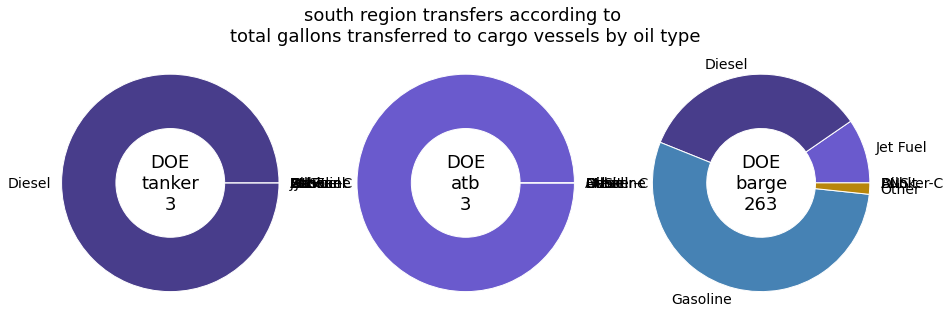

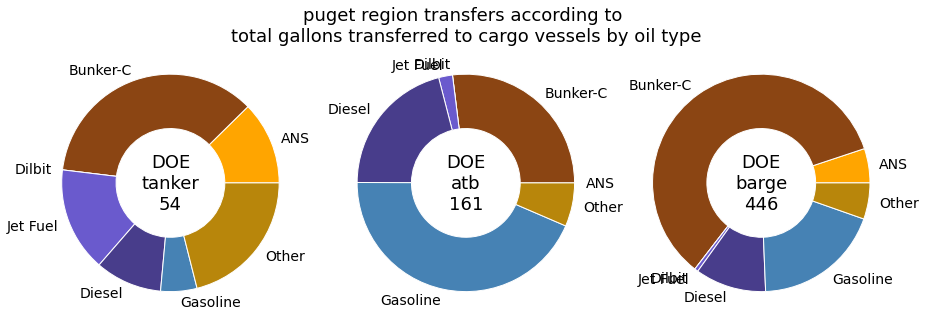

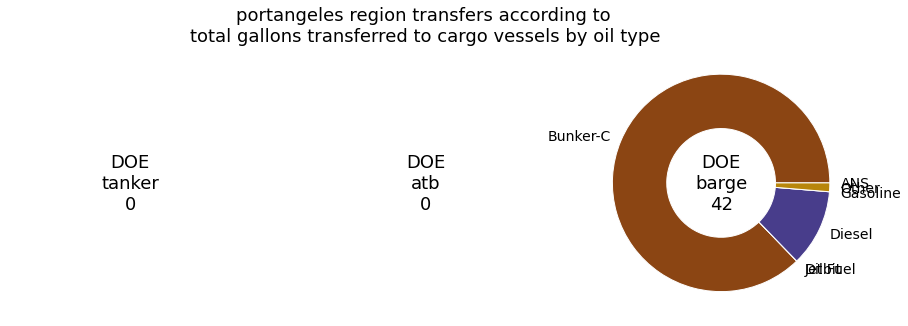

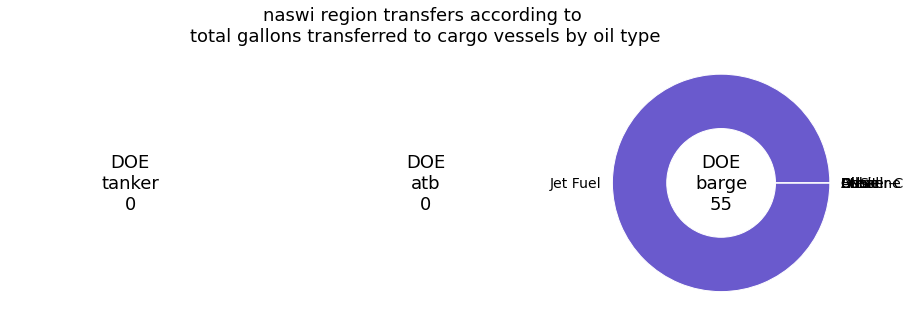

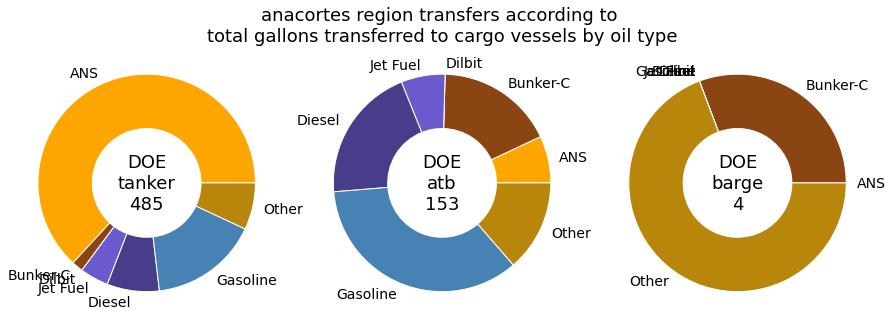

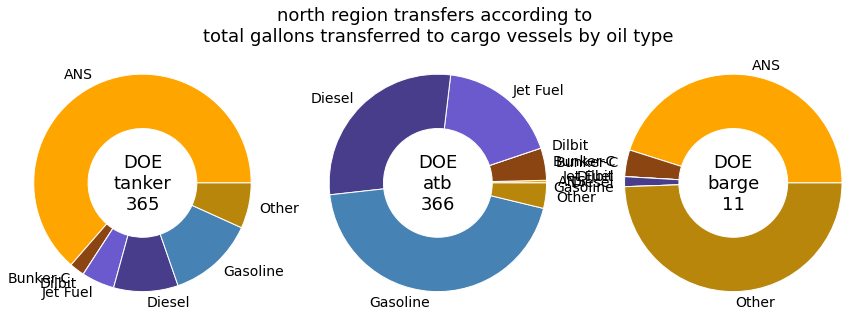

In [7]:
#--------------------------------------------------------------------------------
## Plot department of ecology volume transfers from marine terminals by oil types
#--------------------------------------------------------------------------------
for region in ['south','puget','portangeles','naswi','anacortes','north']:
    fig, axes = plt.subplots(1, 3, figsize = (15,5))
    for idx,vessel in enumerate(["tanker","atb","barge",]):
        # add central title
        axes[idx].axis('equal') 
        if idx==1:
            axes[idx].set_title(
                (f'{region} region transfers according to \n'
                 'total gallons transferred to cargo vessels by oil type'),
                fontsize=18
            )
        # plot up results
        if count_transfers[vessel][region]>0:
            pie_wedge_collection  = axes[idx].pie(
                oil_transfers[vessel][region].values(), 
                labels = oil_transfers[vessel][region].keys(),
                wedgeprops=dict(width=0.5),
                textprops={'fontsize': 14}
            )
        # make colors uniform across subplots
        for pie_wedge in pie_wedge_collection[0]:
            pie_wedge.set_edgecolor('white')
            pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])
            # commented out version parses label to get oil name for color dictionary
            #pie_wedge.set_facecolor(colordict[pie_wedge.get_label().split('(')[0]])
        axes[idx].axis('off')
        axes[idx].text(
            0,0,f'DOE\n{vessel}\n{count_transfers[vessel][region]}',
            ha='center',
            va='center',
            fontsize=18
        )
    #plt.savefig(graphics_directory/'DOE_oil_transfers_byregion.png')

In [8]:
colordict

{'ANS': 'orange',
 'Bunker-C': 'saddlebrown',
 'Diesel': 'darkslateblue',
 'Gasoline': 'steelblue',
 'Jet Fuel': 'slateblue',
 'Dilbit': 'olive',
 'Other': 'darkgoldenrod'}

In [9]:
# Find locations with transfers in our facility list and assign region tag
# First define a value for transfers not included in our evaluation
DOEdf['Region'] = 'not attributed'
for idx,facility in enumerate(facdf['FacilityName']): 
    print(facility)
    DOEdf['Region'] = numpy.where(
        (DOEdf['Deliverer'] == facility) |
        (DOEdf['Receiver'] == facility), # identify transfer location
        facdf['Region'][idx],            # assign region to transfer
        DOEdf['Region']                  # or keep the NA attribution
    )

BP Cherry Point Refinery
Shell Puget Sound Refinery
Shell Oil LP Seattle Distribution Terminal
Maxum Petroleum - Harbor Island Terminal
Tidewater Snake River Terminal
Nustar Energy Tacoma
SeaPort Sound Terminal
Tesoro Vancouver Terminal
Phillips 66 Ferndale Refinery
Phillips 66 Tacoma Terminal
Marathon Anacortes Refinery (formerly Tesoro)
Tesoro Port Angeles Terminal
U.S. Oil & Refining
Naval Air Station Whidbey Island (NASWI)
NAVSUP Manchester
Alon Asphalt Company (Paramount Petroleum)
Kinder Morgan Liquids Terminal - Harbor Island
Nustar Energy Vancouver
Tesoro Pasco Terminal
REG Grays Harbor, LLC
Tidewater Vancouver Terminal
TLP Management Services LLC (TMS)


In [10]:
# check that all facilities in our list are accounted for
region_check = DOEdf.loc[
    (DOEdf['Deliverer'].isin(facdf['FacilityName']) |
     DOEdf['Receiver'].isin(facdf['FacilityName']))
].groupby('Region').count().sort_values(
    by='Deliverer', 
    ascending = False
).Deliverer
region_check.sum()

7655

In [11]:
na_check = DOEdf.loc[
    DOEdf['Region'] == 'not attributed'
].count().Deliverer
na_check

7055

In [12]:
if(len(DOEdf) == na_check + region_check.sum()):
    print(f'{len(DOEdf)} total transfers and all transfers '
          'are labeled with a region')

14710 total transfers and all transfers are labeled with a region
